# DataSet을 감싸고 있는 DataLoader
## 실제로 input과 target을 Dataset을 iter를 돌며 뽑아내 주는 역할

In [1]:
import os
import cv2 as cv
import numpy as np
import glob
import torch
from torch.utils import data
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [32]:
class DataSet(data.Dataset):
    def __init__(self, data_root, transform = None, split = 'train'):
        '''
        data_root : root path to data Image ex. cityscapes/ or kitti/ ...
        split : train or validation split directory 
        ex. cityscapes/train cityscapes/val
        '''
        self.root = data_root
        self.split = split
        
        self.image_path = os.path.join(self.root, self.split) #join -> args들이 string으로 들어오면 해당 string을 path 형식으로 바꿔줌
                                                              #join('kitti', 'train') -> kitti/train
        self.files = glob.glob(self.image_path + "/*.png") #glob.glob -> 해당 path에 있는 파일의 정보를 모아둠 !!이미지를 가져오는건 아님!!
        assert len(self.files) is not 0, f'There are no images in path {self.image_path}'
        
        # Augmentation
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index): #!반드시 getitem의 args에는 index가 있음 Dataloader에서 알아서 넘기고 getitem 함수를 실행시켜, image, target을 가져옴
        #TODO: Load Image from file list (self.files), Data Augmentation, Label Load
        img, label = self.pull_item(index)
        
        #* Need To  Do Transform To Tensor, Data Augmentation, Convert label to right format
        if self.transform is not None:
            img_tf = self.transform(img)
            
        return img_tf, label, img
    
    def pull_item(self, index):
        img_path = self.files[index]
        gt_path = img_path.replace('train', 'label') #! directory의 구성에 맞춰 target을 불러오기 위한 path
        
        img = Image.open(img_path)
        img = np.asarray(img)
        
        label = Image.open(gt_path)
        label = np.asarray(label)
        
        return img, label

In [33]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
        ])

# Compose를 이용하면 여러 augmentation을 간편히 처리 가능

dataset = DataSet(data_root = '../images/kitti_images', transform=transform)

## torch.util 에서 제공하는 dataloader를 이용하면 손쉽게 가능!
### args가 많은데, 나중에 천천히 하나씩 알아보는걸로 ... sampler도 있고 중요함

In [34]:
data_loader = data.DataLoader(dataset, batch_size=1, shuffle=True)

In [35]:
data_iterator = iter(data_loader)
input, target, raw_img = next(data_iterator)

torch.Size([1, 3, 375, 1242])
<class 'torch.Tensor'>
torch.Size([1, 375, 1242, 3])


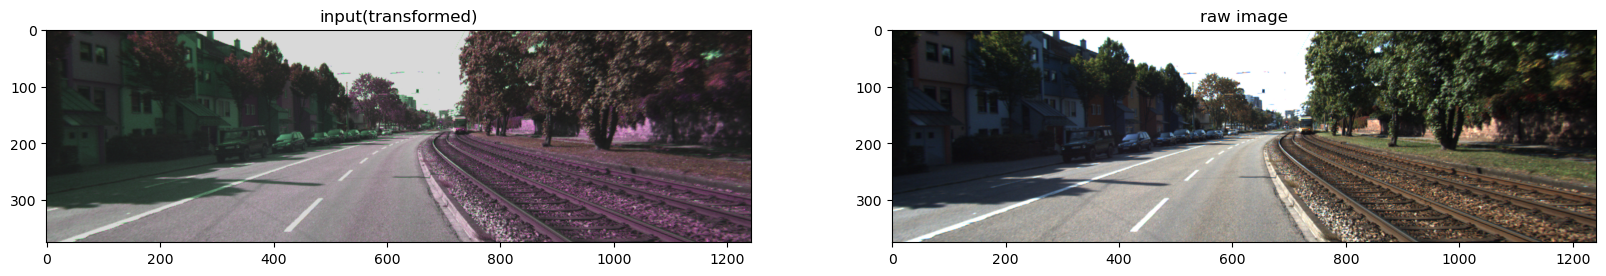

In [41]:
print(input.shape) #[B, C, H, W] Tensor Format
print(type(input))
input_image = input.squeeze(0).permute(1,2,0) #[H, W, C] Image format|
print(raw_img.shape)

fig = plt.figure(figsize=(20,10))
col = 2
raw = 1
ax1 = fig.add_subplot(raw, col, 1)
ax1.imshow(input_image)
ax1.set_title('input(transformed)')
ax2 = fig.add_subplot(raw, col, 2)
ax2.imshow(raw_img.squeeze(0))
ax2.set_title('raw image')
plt.show()